<a href="https://colab.research.google.com/github/22K61A4413/Fruit_Classifier_using_ResNet_Tech/blob/main/fruits_classifier_using_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Core PyTorch (Torch + TorchVision)
!pip install torch torchvision torchaudio --upgrade

# Matplotlib for plotting
!pip install matplotlib --upgrade

# Seaborn for nice plots
!pip install seaborn --upgrade

In [ ]:
from google.colab import drive    # connects drive to this Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path="/content/drive/MyDrive/Fruits Classification.zip"

In [ ]:
import zipfile
import os

extract_folder = "/content/fruits_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("✅ Extraction complete!")

✅ Extraction complete!


In [ ]:
# =============================
# 1. Setup & Imports
# =============================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:
# =============================
# 2. Data Preparation
# =============================
train_dir = "/content/fruits_dataset/Fruits Classification/train"
val_dir = "/content/fruits_dataset/Fruits Classification/valid"

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [ ]:
# =============================
# 3. Model (ResNet18 Pretrained)
# =============================
model = models.resnet18(weights="IMAGENET1K_V1")

# Freeze backbone initially
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


In [ ]:
# =============================
# 4. Training Function
# =============================
def train_model(model, train_loader, val_loader, freeze_epochs=10, total_epochs=20):
    criterion = nn.CrossEntropyLoss()

    # Optimizer for head only
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(total_epochs):
        # Unfreeze backbone after freeze_epochs
        if epoch == freeze_epochs:
            print("🔓 Unfreezing backbone for fine-tuning...")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=1e-4)  # smaller LR for fine-tuning
            scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

        # --- Training ---
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)

        # --- Validation ---
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        scheduler.step()

        print(f"Epoch {epoch+1}/{total_epochs}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return model

In [ ]:
# =============================
# 5. Train with Progressive Unfreeze
# =============================
model = train_model(model, train_loader, val_loader,
                    freeze_epochs=15, total_epochs=20)

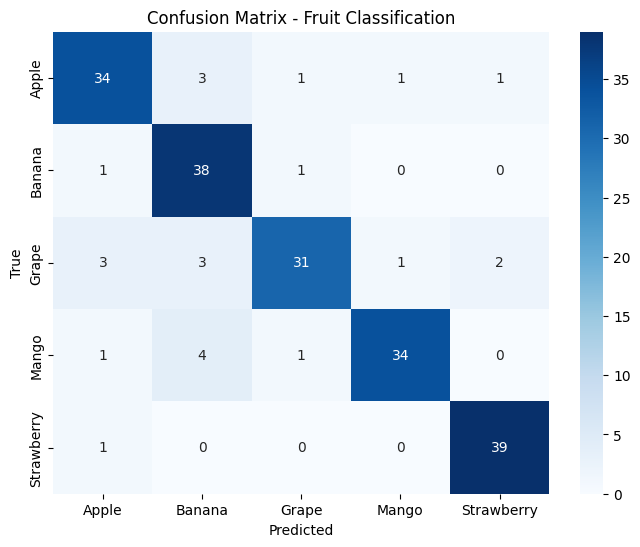


Classification Report:

              precision    recall  f1-score   support

       Apple       0.85      0.85      0.85        40
      Banana       0.79      0.95      0.86        40
       Grape       0.91      0.78      0.84        40
       Mango       0.94      0.85      0.89        40
  Strawberry       0.93      0.97      0.95        40

    accuracy                           0.88       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.88      0.88       200



In [ ]:
# =============================
# 6. Confusion Matrix + Report
# =============================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fruit Classification")
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
import torch
import json

# Save model weights
model_path = "fruit_resnet18_transfer.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved as {model_path}")

# Save class names
classes_path = "class_names.json"
with open(classes_path, "w") as f:
    json.dump(train_dataset.classes, f)
print(f"✅ Class names saved as {classes_path}")

✅ Model saved as fruit_resnet18_transfer.pth
✅ Class names saved as class_names.json


In [ ]:
from google.colab import files

# Download model
files.download(model_path)

# Download class names
files.download(classes_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive    # connects drive to this Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================
# ✅ Install dependencies
# ============================
!pip install flask pyngrok --quiet

In [ ]:
%%writefile app.py
import os
from flask import Flask, request, render_template, send_from_directory
from werkzeug.utils import secure_filename
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
import json

# ----------------------------
# Config
# ----------------------------
UPLOAD_FOLDER = "uploads"
ALLOWED_EXTENSIONS = {"png", "jpg", "jpeg"}
MODEL_PATH = "/content/fruit_resnet18_transfer.pth"
CLASS_PATH = "/content/class_names.json"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs(UPLOAD_FOLDER, exist_ok=True)

def allowed_file(filename):
    return "." in filename and filename.rsplit(".", 1)[1].lower() in ALLOWED_EXTENSIONS

def load_class_names(path):
    with open(path, "r") as f:
        return json.load(f)

def build_model(num_classes):
    model = models.resnet18(weights=None)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Preprocessing
inference_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ----------------------------
# Load Model + Classes
# ----------------------------
class_names = load_class_names(CLASS_PATH)
model = build_model(len(class_names))
state = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)
model.eval()

# ----------------------------
# Flask App
# ----------------------------
app = Flask(__name__, template_folder="templates", static_folder="static")
app.config["UPLOAD_FOLDER"] = UPLOAD_FOLDER

@app.route("/", methods=["GET", "POST"])
def index():
    pred_label = None
    filename = None

    if request.method == "POST":
        file = request.files.get("file")
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            filepath = os.path.join(app.config["UPLOAD_FOLDER"], filename)
            file.save(filepath)

            # Predict
            img = Image.open(filepath).convert("RGB")
            x = inference_tfms(img).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                outputs = model(x)
                _, pred_idx = torch.max(outputs, 1)
                pred_label = class_names[pred_idx.item()]

    return render_template(
        "index.html",
        pred_label=pred_label,
        filename=filename,
        class_names=class_names
    )

@app.route("/uploads/<path:filename>")
def uploaded_file(filename):
    return send_from_directory(app.config["UPLOAD_FOLDER"], filename)

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)


Overwriting app.py


In [ ]:
!mkdir -p templates
!mkdir -p static

In [ ]:
# ============================
# ✅ HTML Template
# ============================


%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8" />
  <title>🍎🍌 Fruit Classifier</title>
  <meta name="viewport" content="width=device-width, initial-scale=1" />
  <link href="{{ url_for('static', filename='styles.css') }}" rel="stylesheet" />
</head>
<body>
  <div class="container">
    <h1>🍎🍌 Fruit Classifier</h1>

    <form method="POST" action="{{ url_for('index') }}" enctype="multipart/form-data" class="upload-card">
      <input id="file" name="file" type="file" accept="image/*" required />
      <button type="submit">Predict</button>
    </form>

    {% if filename %}
      <div class="result">
        <div class="preview">
          <img src="{{ url_for('uploaded_file', filename=filename) }}" alt="Uploaded image" width="300" />
        </div>
        <div class="prediction">
          <h2>Prediction</h2>
          <p class="pred-class">{{ pred_label }}</p>
        </div>
      </div>
    {% endif %}

    <footer>
      <p>Available Classes: {{ ", ".join(class_names) }}</p>
    </footer>
  </div>
</body>
</html>


Overwriting templates/index.html


In [ ]:
%%writefile static/styles.css

body {
  font-family: "Segoe UI", Tahoma, Geneva, Verdana, sans-serif;
  background: #f9fafb;
  margin: 0;
  padding: 0;
  color: #333;
}

.container {
  max-width: 800px;
  margin: 30px auto;
  padding: 20px;
  background: #fff;
  border-radius: 12px;
  box-shadow: 0px 4px 10px rgba(0,0,0,0.1);
  text-align: center;
}

h1 {
  font-size: 2rem;
  margin-bottom: 10px;
}

.subtitle {
  color: #555;
  margin-bottom: 20px;
}

.alert {
  background: #ffdddd;
  border: 1px solid #ff5c5c;
  color: #a10000;
  padding: 10px;
  border-radius: 6px;
  margin-bottom: 20px;
}

.upload-card {
  margin-bottom: 20px;
}

.upload-label {
  display: block;
  font-weight: bold;
  margin-bottom: 8px;
}

input[type="file"] {
  margin: 10px 0;
}

button {
  background: #4cafef;
  border: none;
  padding: 10px 18px;
  font-size: 1rem;
  border-radius: 6px;
  cursor: pointer;
  color: white;
  transition: 0.3s ease;
}

button:hover {
  background: #2196f3;
}

.result {
  display: flex;
  justify-content: space-around;
  align-items: flex-start;
  margin-top: 20px;
  gap: 20px;
  flex-wrap: wrap;
}

.preview img {
  max-width: 250px;
  border-radius: 8px;
  box-shadow: 0px 4px 10px rgba(0,0,0,0.1);
}

.prediction {
  background: #f0f8ff;
  padding: 20px;
  border-radius: 8px;
  flex: 1;
}

.pred-class {
  font-size: 1.5rem;
  font-weight: bold;
  color: #0a6eff;
}

footer {
  margin-top: 30px;
  font-size: 0.9rem;
  color: #666;
}

Overwriting static/styles.css


In [ ]:
!pkill -f flask || echo "No flask running"
!pkill -f ngrok || echo "No ngrok running"
!lsof -i :5000   # check who’s using port 5000
!kill -9 <PID>


^C
^C
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kill -9 <PID>'


In [ ]:
# 🔎 List processes using port 8000
!lsof -i :5000

In [ ]:
# ❌ Kill process by PID (replace 12345 with actual PID from previous cell)
!kill -9 16030

/bin/bash: line 1: kill: (16030) - No such process


In [ ]:
# ============================
# ✅ Run Flask in background
# ============================
!nohup python app.py > flask.log 2>&1 &

In [ ]:
!tail -n 50 flask.log

 * Serving Flask app 'app'
 * Debug mode: off
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
Press CTRL+C to quit


In [ ]:
# ============================
# ✅ Start ngrok tunnel
# ============================
from pyngrok import ngrok, conf

conf.get_default().auth_token = "345YHqwg897i4MK7z0No0PE5qfX_2sQgWGWijH8nskroFwhiF"   # 🔑 put your token here
public_url = ngrok.connect(5000)
print("🌍 Public URL:", public_url)

🌍 Public URL: NgrokTunnel: "https://unjustifiably-warmthless-eleni.ngrok-free.dev" -> "http://localhost:5000"
